# Velocity Ellipsoid Notebook  

Below I compute the velocity ellipsoids inside r-z bins.   
1) Load baseline sample
2) Generate r-z bins and bin middle points for plotting
3) Velocity ellipsoids are computed with 'cov_mat' which takes a r-z bin as input

In [1]:
import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
import data_analysis
import covariance_generation as cov
from import_functions import *
from data_plot import sample_distribution_galactic_coords, plot_radial_distribution, plot_distribution, display_polar_histogram, plot_variance_distribution, plot_velocity_distribution
import numpy as np
import emcee
from functools import reduce
import time, timeit
import transformation_constants
import datetime as dt
import photometric_cut
import os
import pickle
from pathlib import Path
import argparse
import random
import matplotlib.pyplot as plt


Photometric cut..
Stars in the sample before making photometric cuts: (4807089, 22)
Stars in the sample after making photometric cuts: (2528249, 23)
Start import...
The dimensions of the data: (rows, columns) -> (7133471, 24)
Checking indexing... 

<bound method NDFrame.head of                    source_id          ra  ra_error        dec  dec_error  \
0        5933266834310007808  242.471074  0.330682 -52.806533   0.125811   
1        4103049637327213440  278.887615  0.117672 -15.350780   0.103104   
2        5951114420631264640  260.139995  0.042137 -46.794507   0.038528   
3        5966712023814100736  255.893150  0.069434 -41.563702   0.055033   
4        2198292118993038464  331.084711  0.039728  56.898851   0.041073   
...                      ...         ...       ...        ...        ...   
7133466  5959713078252724352  259.808524  0.251540 -41.875976   0.225424   
7133467  4057347680607821696  267.904540  0.079733 -28.918109   0.072635   
7133468  5827538590793373696  234.110

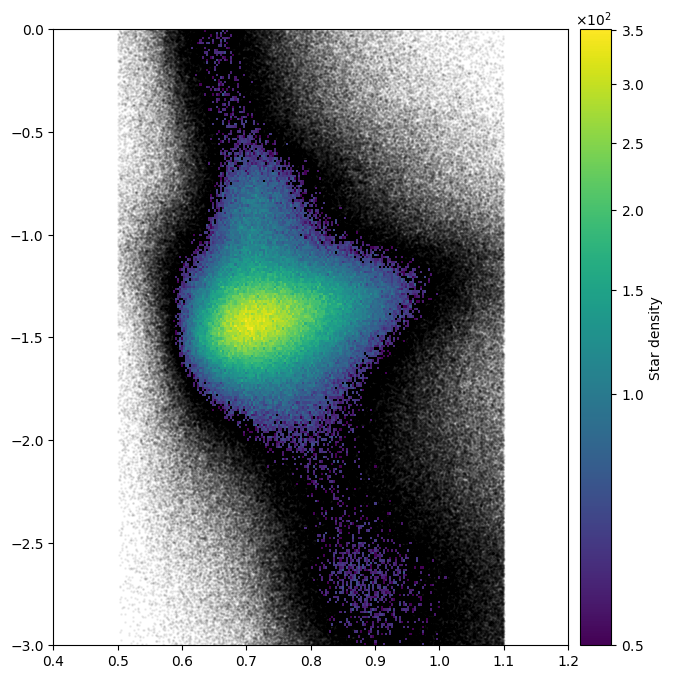

In [2]:
galcen_data, min_r, max_r = import_baseline_sample()

In [3]:
# Generate bins
bin_collection = data_analysis.get_collapsed_bins(data = galcen_data,
                                                      theta = (0, 1),
                                                      BL_r_min = min_r - 1,
                                                      BL_r_max = max_r + 1,
                                                      BL_z_min = -200,
                                                      BL_z_max = 200,
                                                      N_bins = (50, 1),
                                                      r_drift = False,
                                                      debug = False)

In [4]:
bin_mids = []
for i, bin in enumerate(bin_collection.bins):
    bin_mids.append(np.median(bin.r_boundaries))

In [5]:
def cov(x, y):
    x_mean, y_mean = np.mean(x), np.mean(y)
    return np.sum((x-x_mean)*(y-y_mean))/(len(x) - 1)

def cov_mat(bin):
    return np.array([[cov(bin.data.v_r, bin.data.v_r), cov(bin.data.v_r, bin.data.v_phi), cov(bin.data.v_r, bin.data.v_z)],
                    [cov(bin.data.v_r, bin.data.v_phi), cov(bin.data.v_phi, bin.data.v_phi), cov(bin.data.v_phi, bin.data.v_z)],
                    [cov(bin.data.v_r, bin.data.v_z), cov(bin.data.v_phi, bin.data.v_z), cov(bin.data.v_z, bin.data.v_z)]])

# def cov_mat(X):
#     return np.array([[cov(X[0], X[0]), cov(X[0], X[1]), cov(X[0], X[2])],
#                     [cov(X[0], X[1]), cov(X[1], X[1]), cov(X[1], X[2])],
#                     [cov(X[0], X[2]), cov(X[1], X[2]), cov(X[2], X[2])]])

In [6]:
def compute_vertex_deviation(velocity_ellipsoid):

    vel_ell_comps = velocity_ellipsoid[0,1]/(velocity_ellipsoid[0,0] - velocity_ellipsoid[1,1])
    vertex_dev = np.arctan(2 * (vel_ell_comps))/2 

    # Returns in radians
    return vertex_dev

(3, 11)
(3, 31)
(3, 92)
(3, 202)
(3, 412)
(3, 808)
(3, 1356)
(3, 2128)
(3, 2912)
(3, 4049)
(3, 5437)
(3, 6828)
(3, 8307)
(3, 9893)
(3, 11285)
(3, 12084)
(3, 12979)
(3, 13918)
(3, 14088)
(3, 14023)
(3, 14012)
(3, 12101)
(3, 11315)
(3, 11551)
(3, 11114)
(3, 10634)
(3, 9723)
(3, 9052)
(3, 8567)
(3, 8002)
(3, 7405)
(3, 6788)
(3, 6186)
(3, 5213)
(3, 4508)
(3, 3575)
(3, 2837)
(3, 2176)
(3, 1544)
(3, 1114)
(3, 727)
(3, 493)
(3, 299)
(3, 171)
(3, 86)
(3, 54)
(3, 45)
(3, 15)
(3, 8)
(3, 4)


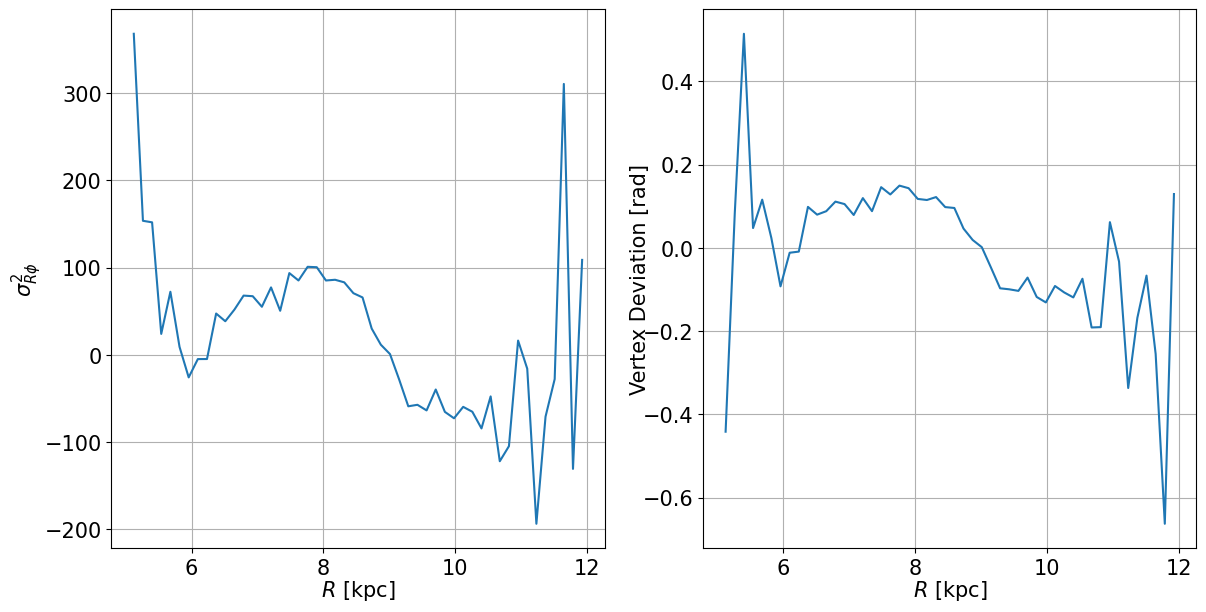

In [7]:
def plot_vertex_deviations(bin_collection):

    velocity_ellipsoids = []
    vertex_devs = []
    for i, bin in enumerate(bin_collection.bins):
    
        vel_data = [bin.data.v_r, bin.data.v_phi, bin.data.v_z]
        vel_data = np.array(vel_data)
        print(vel_data.shape)
        velocity_ellipsoids.append(cov_mat(bin))
        # velocity_ellipsoids.append(cov_mat(vel_data))


        vertex_dev = compute_vertex_deviation(velocity_ellipsoids[i])
        vertex_devs.append(vertex_dev)

    fontdict = {'fontsize' : 15}

    fig, axs = plt.subplots(1,2,figsize = (14, 7))

    axs[0].plot(np.array(bin_mids)/1000, np.array(velocity_ellipsoids)[:,0,1])
    # axs[0].vlines(bin_collection.bin_boundaries[0][0]/1000, 
    #             np.min(np.array(velocity_ellipsoids)[:,0,1]), 
    #             np.max(np.array(velocity_ellipsoids)[:,0,1]),
    #             linestyles='--', color='gray')

    axs[0].set_ylabel(r'$\sigma_{R\phi}^2$', fontdict=fontdict, labelpad=0)
    axs[0].set_xlabel(r'$R$ [kpc]', fontdict=fontdict, labelpad=0)
    axs[0].tick_params(axis='both', which='major', labelsize=15)
    axs[0].grid()

    vertex_devs = []
    for i, bin in enumerate(bin_collection.bins):
        vertex_dev = compute_vertex_deviation(velocity_ellipsoids[i])
        vertex_devs.append(vertex_dev)

    axs[1].plot(np.array(bin_mids)/1000, vertex_devs)
    # axs[1].vlines(bin_collection.bin_boundaries[0][0]/1000, 
    #             np.min(vertex_devs), 
    #             np.max(vertex_devs),
    #             linestyles='--', color='gray')
    #axs[1].set_ylim(-10,8.5)

    axs[1].set_ylabel('Vertex Deviation [rad]', fontdict=fontdict, labelpad=-5)
    axs[1].set_xlabel(r'$R$ [kpc]', fontdict=fontdict, labelpad=0)
    axs[1].tick_params(axis='both', which='major', labelsize=15)
    axs[1].grid()

plot_vertex_deviations(bin_collection)

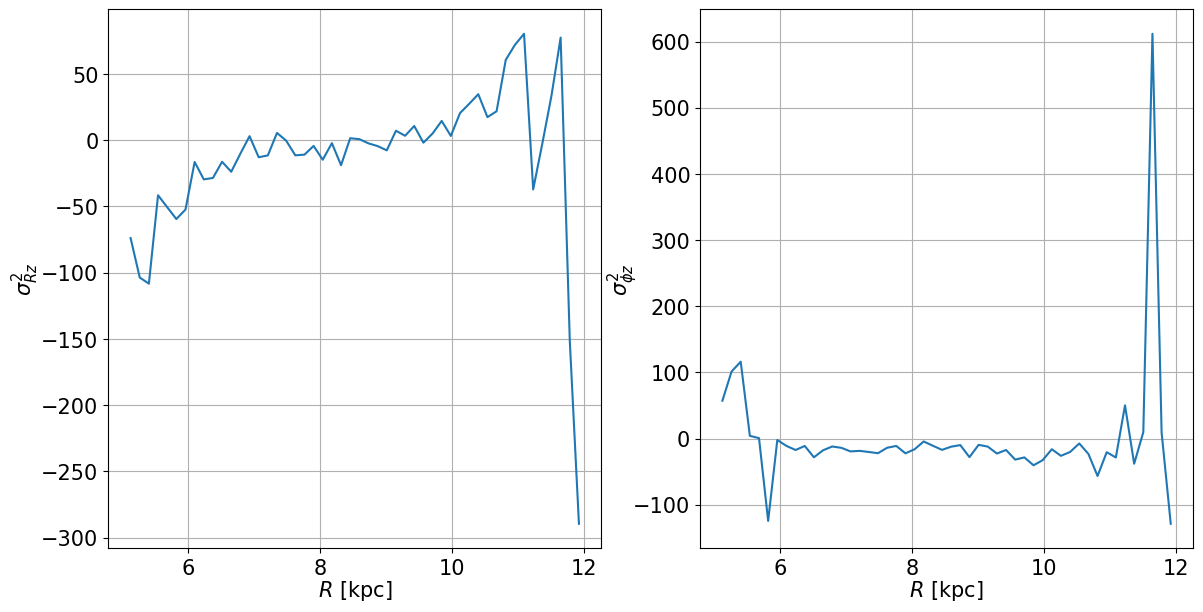

In [8]:
def plot_ellipsoid_components(bin_collection):

    velocity_ellipsoids = []
    vertex_devs = []
    for i, bin in enumerate(bin_collection.bins):
    
        vel_data = [bin.data.v_r, bin.data.v_phi, bin.data.v_z]
        vel_data = np.array(vel_data)
        velocity_ellipsoids.append(cov_mat(bin))
        #velocity_ellipsoids.append(cov_mat(vel_data))

    fontdict = {'fontsize' : 15}

    fig, axs = plt.subplots(1,2,figsize = (14, 7))

    axs[0].plot(np.array(bin_mids)/1000, np.array(velocity_ellipsoids)[:,0,2])
    # axs[0].vlines(bin_collection.bin_boundaries[0][0]/1000, 
    #             np.min(np.array(velocity_ellipsoids)[:,0,2]), 
    #             np.max(np.array(velocity_ellipsoids)[:,0,2]),
    #             linestyles='--', color='gray')

    axs[0].set_ylabel(r'$\sigma_{Rz}^2$', fontdict=fontdict, labelpad=0)
    axs[0].set_xlabel(r'$R$ [kpc]', fontdict=fontdict, labelpad=0)
    axs[0].tick_params(axis='both', which='major', labelsize=15)
    axs[0].grid()


    axs[1].plot(np.array(bin_mids)/1000, np.array(velocity_ellipsoids)[:,2,1])
    # axs[1].vlines(bin_collection.bin_boundaries[0][0]/1000, 
    #             np.min(np.array(velocity_ellipsoids)[:,2,1]), 
    #             np.max(np.array(velocity_ellipsoids)[:,2,1]),
    #             linestyles='--', color='gray')


    axs[1].set_ylabel(r'$\sigma_{\phi z}^2$', fontdict=fontdict, labelpad=-5)
    axs[1].set_xlabel(r'$R$ [kpc]', fontdict=fontdict, labelpad=0)
    axs[1].tick_params(axis='both', which='major', labelsize=15)
    axs[1].grid()

plot_ellipsoid_components(bin_collection)